In [1]:
from reweight_functions import *
import pickle

### SETTING THE DIRECTORIES TO THE EXPERIMENTAL, COMPUTED DATA AND MAKING DIRECTORIES FOR THE OUTPUT AND FOR SAVING THE REWEIGHTED RMSES AS DICTIONARIES IN THEIR OWN DIRECTORIES

In [2]:
main_path = '/Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN'

outdir = os.path.join(main_path, 'Charmm36m', 'reweight_kish_tiny')
datadir = os.path.join(main_path, 'Charmm36m', 'Average_Data')
expdatadir = os.path.join(main_path, 'Exp_Data')
weights_dir = os.path.join(outdir, 'weights')

if not os.path.exists(outdir):
    os.makedirs(outdir)
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

single_dir = os.path.join(weights_dir + "/single_data")
if not os.path.exists(single_dir):
    os.makedirs(single_dir)
leave_dir = os.path.join(weights_dir + "/leave_one_data")
if not os.path.exists(leave_dir):
    os.makedirs(leave_dir)
combined_dir = os.path.join(weights_dir + "/combined_data")
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

dic_dir = os.path.join(outdir, 'dictionaries')
if not os.path.exists(dic_dir):
    os.makedirs(dic_dir)


### SETTING THE REWEIGHTING KEYS (DATA TYPES TO USE IN THE REWEIGHTING PROCEDURE)

In [3]:
chemical_shifts = ['CB', 'HA', 'CA', 'H', 'N', 'C']

colors = {'C': 'royalblue', 'HA': 'orange', 'CA': 'red', 'CB': 'forestgreen', 'H': 'mediumorchid',
            'N': 'darkslateblue', 'JHNHA': 'cornflowerblue', 'Rg': 'grey', 'RDC': 'firebrick', 'SAXS': 'teal',
            'PRE_2': 'mediumpurple', 'PRE_59': 'rebeccapurple', 'Tot': 'black'}

theta_0 = {'HA': 1., 'CA': 1, 'CB': 1., 'C': 1., 'H': 1., 'HA2': 1., 'HA3': 1., 'N': 1., 'RDC': 1., 'Rg': 1.,
            'JHNHA': 1., 'SAXS': 1., 'PRE_2': 1, 'PRE_59': 1.}
to_remove = ['HA2', 'HA3', 'N']
reweighting_keys = ['CA', 'CB', 'H', 'HA', 'C', 'PRE_2', 'PRE_59', 'JHNHA', 'SAXS', 'RDC']

print('Main settings:\n')
print('Reweighting keys: {}'.format(reweighting_keys))


Main settings:

Reweighting keys: ['CA', 'CB', 'H', 'HA', 'C', 'PRE_2', 'PRE_59', 'JHNHA', 'SAXS', 'RDC']


### LOADING THE EXPERIMENTAL AND COMPUTED DATA.

### Data Parsing Functions

These functions read files and organize the data into nested dictionary structures. 

#### Function: `read_cs_md(data)`/`read_exp_cs(data)`

- **Input:** A file path to a comma-separated values (CSV) file for chemical shifts/PREs/SAXS profiles.
- **Output:** A nested dictionary with keys (`'HA'`, `'CA'`, `'CB'`, etc.) corresponding to a data-type, where:
  - The first element of each line is used as an inner dictionary key which could be a residue number for shifts or scattering angle for SAXS etc.
  - The values are numpy arrays of floats corresponding to the time-series data from simulation or the ensemble average experimental data.

#### Function: `Align_Comp_Exp_Data`

- **Input:** The compdata and expdata dictionaries we generate from function above.

- **Output:** New updated dictionaries for both such that they have information for common residue numbers/scattering angles etc. This is useful when the experimental data you have has information missing for certain residues but the computed shifts from SPARTA+ has time-series data for every residue.

In [4]:
expdata = read_exp_cs(join(expdatadir, 'CS.exp.dat'))
compdata = read_cs_md(join(datadir, 'chemical_shifts.all.csv'), )

expdata = add_exp_data(join(expdatadir, 'RDC.exp.dat'), expdata, 'RDC')
compdata = add_md_data(join(datadir, 'RDC.all.csv'), compdata, 'RDC')

expdata = add_exp_data(join(expdatadir, 'JHNHA.exp.dat'), expdata, 'JHNHA')
compdata = add_md_data(join(datadir, 'J_HNHA0.all.csv'), compdata, 'JHNHA')

expdata = add_exp_data(expdatadir + '/SAXS.exp.dat', expdata, 'SAXS')
compdata = add_md_data(datadir + '/SAXS.csv', compdata, 'SAXS')

# Remove the '# drho = 3.34 ; r0 = 1.68' entry from compdata['SAXS']
compdata['SAXS'].pop('# drho = 3.34 ; r0 = 1.68', None)

# Replace each key in compdata['SAXS'] with the corresponding key from expdata['SAXS']
new_compdata_saxs = {}
for exp_key, comp_key in zip(expdata['SAXS'].keys(), compdata['SAXS'].keys()):
    new_compdata_saxs[exp_key] = compdata['SAXS'][comp_key]

# Replace the original compdata['SAXS'] with the new dictionary
compdata['SAXS'] = new_compdata_saxs

expdata = add_exp_data(expdatadir + '/Iratio-label-2.exp.dat', expdata, 'PRE_2')
compdata = add_md_data(datadir + '/Iratio-label-2.all.csv', compdata, 'PRE_2')

expdata = add_exp_data(expdatadir + '/Iratio-label-59.exp.dat', expdata, 'PRE_59')
compdata = add_md_data(datadir + '/Iratio-label-59.all.csv', compdata, 'PRE_59')

# Elimination of compdata that are not in expdata and viceversa
compdata, expdata = Align_Comp_Exp_Data(compdata, expdata)


nframes = len(compdata[list(compdata.keys())[1]][list(compdata[list(compdata.keys())[1]].keys())[0]])

# labels
exp_labels = list(compdata.keys())
true_exp_labels = [key for key in exp_labels if key not in to_remove]

print(
    'Correctely acquired data from experiments and for MD simulations for the following quantities:\n{}\nNumber of frames = {}'.format(
        [str(key) for key in compdata.keys()], nframes))

Correctely acquired data from experiments and for MD simulations for the following quantities:
['HA', 'CA', 'CB', 'C', 'H', 'HA2', 'HA3', 'N', 'RDC', 'JHNHA', 'SAXS', 'PRE_2', 'PRE_59']
Number of frames = 29976


### Reweighting and Validation Procedure

This code block initializes the reweighting process by putting the reweighting keys information in dictionaries.

#### Initialization
- `sd`: Dictionary to store standard deviations.
- `To_Scan`: List of keys to process for reweighting.

#### Separation of Data
- **Separate Reweight and Validation Data:**
 This function separates the input `CS` items and `true_exp_labels` into two distinct sets: `Reweight_Data` and `Validation_Data`.
 - **Inputs:**
  - `CS`: Can be a single key or list of keys.
  - `true_exp_labels`: A list of labels for the data-types used.

- **Outputs:**
  - `CS`: A string representation of the `CS` keys.
  - `Reweight_Data`: A list of keys (data-types) that need reweighting.
  - `Validation_Data`: A list of validation items, which are the remaining items in `true_exp_labels` after removing `CS` items.

#### Function: `Process_Data_Into_Arrays(data, expdata, compdata, err_d, compare_dict)`

- **Inputs:**
  - `data`: List of keys representing either Reweight_Data or Validation_Data.
  - `expdata`: Dictionary of experimental data.
  - `compdata`: Dictionary of computed MD timeseries data.
  - `err_d`: Dictionary of regularization parameter values which are all initialized at 1.0 for each data-type.
  - `compare_dict`: Dictionary to store comparison data.

- **Outputs:**
  - `exp`: Numpy array of experimental values.
  - `traj`: Numpy array of MD timeseries data.
  - `data_t`: List of data types (keys) (either r for reweight or v for validation).
  - `data_type`: Dictionary mapping keys to boolean arrays indicating the presence of data.
  - `compare_dict`: Updated comparison dictionary.


In [5]:
sd = {}
To_Scan = reweighting_keys
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    print('Validation Data = {}'.format(Validation_Data))

    ### debugging variables
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    # i) Process Reweight data into arrays 
    obs_exp_r, traj_r, err_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays(Reweight_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_r)

    # ii) Process Validation data into arrays 
    obs_exp_v, traj_v, err_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays(Validation_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_v)

    # final_weights

    for key in data_v_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_v[key]:
            timeseries = compare_dict_v[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_v[key][key2][0]), float(ave), float(sigma)])

    for key in data_r_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_r[key]:
            timeseries = compare_dict_r[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_r[key][key2][0]), float(ave), float(sigma)])

Reweight Data = CA
Validation Data = ['HA', 'CB', 'C', 'H', 'RDC', 'JHNHA', 'SAXS', 'PRE_2', 'PRE_59']
HA
CB
C
H
RDC
JHNHA
SAXS
PRE_2
PRE_59
CA
Reweight Data = CB
Validation Data = ['HA', 'CA', 'C', 'H', 'RDC', 'JHNHA', 'SAXS', 'PRE_2', 'PRE_59']
HA
CA
C
H
RDC
JHNHA
SAXS
PRE_2
PRE_59
CB
Reweight Data = H
Validation Data = ['HA', 'CA', 'CB', 'C', 'RDC', 'JHNHA', 'SAXS', 'PRE_2', 'PRE_59']
HA
CA
CB
C
RDC
JHNHA
SAXS
PRE_2
PRE_59
H
Reweight Data = HA
Validation Data = ['CA', 'CB', 'C', 'H', 'RDC', 'JHNHA', 'SAXS', 'PRE_2', 'PRE_59']
CA
CB
C
H
RDC
JHNHA
SAXS
PRE_2
PRE_59
HA
Reweight Data = C
Validation Data = ['HA', 'CA', 'CB', 'H', 'RDC', 'JHNHA', 'SAXS', 'PRE_2', 'PRE_59']
HA
CA
CB
H
RDC
JHNHA
SAXS
PRE_2
PRE_59
C
Reweight Data = PRE_2
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'RDC', 'JHNHA', 'SAXS', 'PRE_59']
HA
CA
CB
C
H
RDC
JHNHA
SAXS
PRE_59
PRE_2
Reweight Data = PRE_59
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'RDC', 'JHNHA', 'SAXS', 'PRE_2']
HA
CA
CB
C
H
RDC
JHNHA
SAXS
PRE_2

### INITIAL ROUND OF REWEIGHTING FOR A RANGE OF SIGMA_REG VALUES FOR EACH INDIVIDUAL DATA TYPE

### Reweighting Procedure with range of Regularization Parameters for one data-type at a time

This code performs a reweighting procedure over a range of regularization parameters (`thetas`) to evaluate the impact on root mean square error (RMSE) and Kish effective size.

#### Initialization
- **Variables:**
  - `To_Scan`: List of keys for reweighting.
  - `thetas`: Array of regularization parameters.
  - `ref_theta`: Reference value from `thetas`.
  - `RMSE_dict`: Dictionary to store RMSE values.
  - `KishScan_one_data`: Dictionary to store Kish effective size data.

#### Separation of Data
For each key in `To_Scan`:
- **Separate Reweight and Validation Data:**
- **Process_Data_Into_Arrays_with_sigma:** (store the information in dictionaries and calculate $/sigma_{MD}$ with block analysis)
- **Perform reweighting process per regularization value per data-type and minimize using L-BFGS algorithm**

For each data-type and iteration:

- **RMSEs and Kish values are calculated:**
  - **Kish Effective Size** (`Kish_ratio`): Measures the effective sample size after reweighting.
  - **RMSE (Root Mean Square Error):**
    - `RMSE_r_i`: Initial RMSE for Reweight Data.
    - `RMSE_r_f`: Final RMSE for Reweight Data.
    - `RMSE_v_i`: Initial RMSE for Validation Data.
    - `RMSE_v_f`: Final RMSE for Validation Data.

- **Results are stored in dictionaries:**
  - `RMSE_dict[CS][s]`: Stores Kish effective size and RMSE values for each regularization parameter (`theta_m`).
  - `KishScan_one_data[CS]`: Stores the list of `theta` values and their corresponding Kish effective sizes and final RMSE values for further analysis.




### Applying our Reweighting Theory Here

```python
def func_sigma_reg_sigma_md(l, traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md):
    l = np.array(l)  
    weight_all = +weight_bias  
    weight_all -= np.dot(l, traj_r)  
    shift_all = np.max(weight_all)  
    weight_all = np.exp(weight_all - shift_all)  
    weight_0 = +weight_bias  
    shift_0 = np.max(weight_0)  
    weight_0 = np.exp(weight_0 - shift_0)  

    # Gamma/Lagrange function in maxent:
    # Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + shift_all - shift_0 + np.dot(l, obs_exp_r)

    # Derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r, weight_all) / np.sum(weight_all)  # Derivative with respect to l

    f += 0.5 * np.sum((sigma_reg * sigma_reg) * l ** 2 + sigma_md * sigma_md * l ** 2)
    der += sigma_reg * sigma_reg * l + sigma_md * sigma_md * l
    return f, der




Gamma function in the code refers to the following:
$$
 \mathcal{L} = D_{KL}[P_1|P_0]  - \sum_{i=1}^M \lambda_i \left [ \int P_1(x) f_i(x) dx - f_i^{\text{exp}} \right ] - \mu \left [ \int P_1 (x) dx - 1 \right ] 
$$
Derivative of the function is the following:
$$
\frac{\delta \mathcal{L}}{\delta P_1} = -\ln \frac{P_1}{P_0} - 1 - \sum_{i=1}^{M} \lambda_i f_i(\mathbf{x}) - \mu
$$
 The $\sigma$ values for reweighting is given by:
$$
\sigma_{i} = \sqrt{\sigma_{i,\text{MD}}^2 + \sigma_{\text{reg}}^2}
$$






In [6]:
To_Scan = reweighting_keys
thetas = np.linspace(0.001, 20, 200)
ref_theta = thetas[-1]
RMSE_dict = {}
KishScan_one_data = {}


for CS in To_Scan:
        CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
        KishScan_one_data[CS] = {}
        print('Reweight Data = {}'.format(CS))
        RMSE_dict[CS] = {}

        ### debugging variables
        compare = []
        compare_dict_r = {key: {} for key in compdata.keys()}
        compare_dict_v = {key: {} for key in compdata.keys()}

        ####### B) The reweighting procedure

        obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
            Reweight_Data, expdata, compdata, theta_0, sd, compare_dict_r)
        obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
            Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

        # THETA CYCLE
        theta_list = []
        kish_list = []
        rmsd_f_list = []
        for theta_m in np.flip(thetas):

            s = '{:.2f}'.format(theta_m)
            # print(s)
            sigma_reg = theta_m * err_r
            sigma_md = sigma_md_r
            RMSE_dict[CS][s] = {}

            # iv) Print dimensions
            nobs_r = len(obs_exp_r)
            nobs_v = len(obs_exp_v)
            # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

            # v) perform minimization
            # OBS: res.X = lagrange multiplier
            weight_bias = np.ones(nframes)

            if 'RDC' in Reweight_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_r = np.dot(traj_r, initial_weights)
                initial_obs_r
                exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_r_type['RDC'] == 1)
                traj_r[RDC_rows] = traj_r[RDC_rows] * c

            if 'RDC' in Validation_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_v = np.dot(traj_v, initial_weights)
                exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_v_type['RDC'] == 1)
                traj_v[RDC_rows] = traj_v[RDC_rows] * c

            res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                       args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                       x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
            initial_weights = Normalize_Weights(weight_bias)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_v = np.dot(traj_v, initial_weights)

            final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
            final_obs_r = np.dot(traj_r, final_weights)
            final_obs_v = np.dot(traj_v, final_weights)
            # g) calculating Kish effective size
            Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
            Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

            Kish_ratio = (Ks_a / Ks_b) * 100
            RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
            RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            theta_list.append(theta_m)
            kish_list.append(Kish_ratio)
            rmsd_f_list.append(RMSE_reweight)
            RMSE_r_i = {}
            RMSE_v_i = {}
            RMSE_r_f = {}
            RMSE_v_f = {}
            RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_i[t] = np.sqrt(
                    np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_i['RDC'] = qf

            RMSE_v_i['Tot'] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            for t in data_v_type:
                RMSE_v_i[t] = np.sqrt(
                    np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_i['RDC'] = qf

            RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_f['RDC'] = qf

            for t in data_v_type:
                RMSE_v_f[t] = np.sqrt(np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_f['RDC'] = qf

            RMSE_dict[CS][s]['Kish'] = Kish_ratio
            RMSE_dict[CS][s]['r_i'] = RMSE_r_i
            RMSE_dict[CS][s]['r_f'] = RMSE_r_f
            RMSE_dict[CS][s]['v_i'] = RMSE_v_i
            RMSE_dict[CS][s]['v_f'] = RMSE_v_f

        KishScan_one_data[CS]['kish'] = np.column_stack((theta_list, kish_list))
        KishScan_one_data[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweight Data = CA
Reweight Data = CB
Reweight Data = H
Reweight Data = HA
Reweight Data = C
Reweight Data = PRE_2
Reweight Data = PRE_59
Reweight Data = JHNHA
Reweight Data = SAXS
Reweight Data = RDC


### Finding Optimal Regularization Parameter

This code iterates through `KishScan_one_data` to find a `theta_m` that meets a minimum Kish ratio (`kish_min`). It selects the last `theta_m` value above `kish_min` and, if zero, uses the second-to-last value.

#### Process:
- **Initialization:**
  - `kish_min = 10`: Minimum threshold for the Kish ratio.
  - `theta_dict`: Dictionary to store selected `theta_m` values for each `key` in `KishScan_one_data`.
  - `Kish_ratio_vals`: List to collect `theta_m` values meeting the `kish_min` criteria.

- **Iteration:**
  - For each `key` in `KishScan_one_data`:
    - Retrieve Kish ratios (`kish`) from `KishScan_one_data[key]['kish']`.
    - Identify indices (`b`) where Kish ratio meets or exceeds `kish_min`.
    - Select `theta_m` as the last valid value (so lowest value) from `kish` that meets the criteria.
    - If `theta_m` is zero, fallback to the second-to-last valid value (`k[idy][0]`).
    - Store `theta_m` in `theta_dict[key]`.

- **Output:**
  - `theta_dict`: Dictionary mapping each key to the selected `theta_m` that meets the `kish_min` criteria.


In [7]:
kish_min = 0.01
theta_dict = {}
Kish_ratio_vals = []
for key in KishScan_one_data:
    k = KishScan_one_data[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict[key] = {}
    theta_dict[key] = (theta_m)


In [8]:
def print_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
            "RMSD final: %0.4f" % RMSE_reweight)

    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Initial RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
  
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
 
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_f, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
           
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)


### Reweighting Individual Data-Types based on optimal regularization parameter as found above
- We found optimal regularization paramters as discussed above
- We run the same reweighting process on each data type for it's own optimal regularization parameter instead of iterating over a range of values

In [9]:
To_Scan = reweighting_keys

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    CS_dir = join(single_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
        Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    theta_m = theta_dict[CS]
    s = '{:.2f}'.format(theta_m)
    print(s)
    sigma_reg = theta_m
    sigma_md = sigma_md_r


    # iv) Print dimensions
    nobs_r = len(obs_exp_r)
    nobs_v = len(obs_exp_v)

    # v) perform minimization
    # OBS: res.X = lagrange multiplier
    weight_bias = np.ones(nframes)
    if 'RDC' in Reweight_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_r
        exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_r_type['RDC'] == 1)
        traj_r[RDC_rows] = traj_r[RDC_rows] * c

    if 'RDC' in Validation_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)
        initial_obs_v
        exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_v_type['RDC'] == 1)
        traj_v[RDC_rows] = traj_v[RDC_rows] * c

    res = sp.optimize.minimize(func_sigma_reg_sigma_md, args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
    initial_weights = Normalize_Weights(weight_bias)
    initial_obs_r = np.dot(traj_r, initial_weights)
    initial_obs_v = np.dot(traj_v, initial_weights)
    final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
    # e) final average observables for reweighting and validation
    final_obs_r = np.dot(traj_r, final_weights)
    final_obs_v = np.dot(traj_v, final_weights)
    # g) calculating Kish effective size
    Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
    Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)
    Kish_ratio = (Ks_a / Ks_b) * 100
    RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
    RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
    print_results()

   
    np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
    # print final weights to file

    f = open("%s/weights_final.a.dat" % CS_dir, "w")
    for w in final_weights:
        f.write("%e\n" % w)
    f.close()


Reweight Data = CA
0.00
CA Theta: 0.001 Kish:  0.041660 RMSD initail: 0.7609 RMSD final: 0.3680
Initial RMSE reweight data 
 * Total :      0.761
 *    CA :      0.761
Initial RMSE validation data
 * Total :      0.589
 *    HA :      0.170
 *    CB :      0.646
 *     C :      0.651
 *     H :      0.169
 *    RDC :      1.056
 *    RDC scaled Q:  0.944
 *    JHNHA :      1.050
 *    SAXS :      0.004
 *    PRE_2 :      0.296
 *    PRE_59 :      0.380
Final RMSE reweight data
 * Total :      0.368
 *    CA :      0.368
Final RMSE validation data
 * Total :      0.517
 *    HA :      0.108
 *    CB :      0.403
 *     C :      0.612
 *     H :      0.220
 *    RDC :      1.063
 *    RDC Q_scaled:  0.950
 *    JHNHA :      0.898
 *    SAXS :      0.004
 *    PRE_2 :      0.160
 *    PRE_59 :      0.366
Reweight Data = CB
0.00
CB Theta: 0.001 Kish:  0.088712 RMSD initail: 0.6458 RMSD final: 0.1006
Initial RMSE reweight data 
 * Total :      0.646
 *    CB :      0.646
Initial RMSE valida

### REWEIGHTING ON A RANGE OF PARAMETER VALUES AFTER COMBINING ALL DATA

#### Initialization
- We combine all the data-types as a single key to pass
- **Variables:**
  - `To_Scan`: List of keys for reweighting which is a string of combined data ('CA-CB-H-JHNHA-N-RDC-HA').
  - `thetas`: Array of regularization parameters.
  - `ref_theta`: Reference value from `thetas`.
  - `RMSE_dict`: Dictionary to store RMSE values.
  - `KishScan_combined`: Dictionary to store Kish effective size data.

#### Separation of Data
For each key in `To_Scan`:
- **Separate Reweight and Validation Data:**
- **Process_Data_Into_Arrays_with_sigma:** (store the information in dictionaries and calculate $/sigma_{MD}$ with block analysis)
- **Perform reweighting process per regularization value per data-type and minimize using L-BFGS algorithm**

For each data-type and iteration:

- **RMSEs and Kish values are calculated:**
  - **Kish Effective Size** (`Kish_ratio`): Measures the effective sample size after reweighting.
  - **RMSE (Root Mean Square Error):**
    - `RMSE_r_i`: Initial RMSE for Reweight Data.
    - `RMSE_r_f`: Final RMSE for Reweight Data.
    - `RMSE_v_i`: Initial RMSE for Validation Data.
    - `RMSE_v_f`: Final RMSE for Validation Data.

- **Results are stored in dictionaries:**
  - `RMSE_dict_combined[CS][s]`: Stores Kish effective size and RMSE values for each regularization parameter (`theta_m`).
  - `KishScan_combinedCS]`: Stores the list of `theta` values and their corresponding Kish effective sizes and final RMSE values for further analysis.

In [10]:
combined_reweighting_keys = [reweighting_keys]
print('Reweighting keys: {}'.format(combined_reweighting_keys))

To_Scan = combined_reweighting_keys
thetas = np.linspace(0.01, 20, 20)
ref_theta = thetas[-1]
RMSE_dict_combined = {}
KishScan_combined = {}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan_combined[CS] = {}
    CS_dir = join(combined_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)
    print('Reweight Data = {}'.format(CS))
    RMSE_dict_combined[CS] = {}
    combined_key_string = CS

    ### debugging variables
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    # THETA CYCLE
    theta_list = []
    kish_list = []
    rmsd_f_list = []
    for theta_m in np.flip(thetas):

        s = '{:.2f}'.format(theta_m)
        print(s)
        sigma_reg = theta_m * err_r
        sigma_md = sigma_md_r
      
        RMSE_dict_combined[CS][s] = {}

        # iv) Print dimensions
        nobs_r = len(obs_exp_r)
        nobs_v = len(obs_exp_v)
        # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

        # v) perform minimization
        # OBS: res.X = lagrange multiplier
        weight_bias = np.ones(nframes)
        if 'RDC' in Reweight_Data:
            initial_weights = weight_bias
            initial_weights /= np.sum(initial_weights)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_r
            exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
            calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
            qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
            qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

            if (qf_neg < qf_pos):
                c = -c_neg
            else:
                c = c_pos

            RDC_rows = np.where(data_r_type['RDC'] == 1)
            traj_r[RDC_rows] = traj_r[RDC_rows] * c

        res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                    args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                    x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
        initial_weights = Normalize_Weights(weight_bias)
        initial_obs_r = np.dot(traj_r, initial_weights)
        # if res.success: print("\nMinimization worked: {}\n".format(res.success))
        # else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
        final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
        # e) final average observables for reweighting and validation
        final_obs_r = np.dot(traj_r, final_weights)

        # g) calculating Kish effective size
        Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
        Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

        Kish_ratio = (Ks_a / Ks_b) * 100
        RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
        RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
        # print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)
        theta_list.append(theta_m)
        kish_list.append(Kish_ratio)
        rmsd_f_list.append(RMSE_reweight)
        RMSE_r_i = {}
        RMSE_r_f = {}
        RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

        for t in data_r_type:
            RMSE_r_i[t] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_i['RDC'] = qf

        RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
        for t in data_r_type:
            RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_f['RDC'] = qf

        RMSE_dict_combined[CS][s]['Kish'] = Kish_ratio
        RMSE_dict_combined[CS][s]['r_i'] = RMSE_r_i
        RMSE_dict_combined[CS][s]['r_f'] = RMSE_r_f
    KishScan_combined[CS]['kish'] = np.column_stack((theta_list, kish_list))
    KishScan_combined[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweighting keys: [['CA', 'CB', 'H', 'HA', 'C', 'PRE_2', 'PRE_59', 'JHNHA', 'SAXS', 'RDC']]
Reweight Data = CA-CB-H-HA-C-PRE_2-PRE_59-JHNHA-SAXS-RDC
20.00
18.95
17.90
16.84
15.79
14.74
13.69
12.64
11.58
10.53
9.48
8.43
7.37
6.32
5.27
4.22
3.17
2.11
1.06
0.01


### Finding Optimal Regularization Parameter for Combined Data Reweighting

This code iterates through `KishScan_combined` to find a `theta_m` that meets a minimum Kish ratio (`kish_min`). It selects the last `theta_m` value above `kish_min` and, if zero, uses the second-to-last value.

#### Process:
- **Initialization:**
  - `kish_min = 10`: Minimum threshold for the Kish ratio.
  - `theta_dict`: Dictionary to store selected `theta_m` values for each `key` in `KishScan_combined`.
  - `Kish_ratio_vals`: List to collect `theta_m` values meeting the `kish_min` criteria.

- **Iteration:**
  - For each `key` in `KishScan_combined`:
    - Retrieve Kish ratios (`kish`) from `KishScan_combined[key]['kish']`.
    - Identify indices (`b`) where Kish ratio meets or exceeds `kish_min`.
    - Select `theta_m` as the last valid value (so lowest value) from `kish` that meets the criteria.
    - If `theta_m` is zero, fallback to the second-to-last valid value (`k[idy][0]`).
    - Store `theta_m` in `theta_dict_combined[key]`.

- **Output:**
  - `theta_dict_combined`: Dictionary mapping each key to the selected `theta_m` that meets the `kish_min` criteria.

In [11]:
kish_min = 0.01
theta_dict_combined = {}
Kish_ratio_vals = []
for key in KishScan_combined:
    k = KishScan_combined[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict_combined[key] = {}
    theta_dict_combined[key] = (theta_m)
    print(key, theta_m)

CA-CB-H-HA-C-PRE_2-PRE_59-JHNHA-SAXS-RDC 0.01


In [12]:
def print_comb_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
          "RMSD final: %0.4f" % RMSE_reweight)

    # Iniitial RMSE and Sigma
    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print(
            "     %6.3lf" % np.sqrt(np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                               obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC scaled RMSD:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC RMSE_scale:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

### FUNCTION TO PLOT THE FITTING DATA

In [13]:
PREs=['PRE_2', 'PRE_59']
from matplotlib.ticker import StrMethodFormatter

def plot_fitting_data(weights):
    for t in Reweight_Data:
        if t != 'Rg':
            print(t)
            resid = []
            exp = []
            for i, id in enumerate(compare_dict_r[t]):
                resid.append(float(id))
            initial = np.trim_zeros(initial_obs_r * data_r_type[t])
            reweight = np.trim_zeros(final_obs_r * data_r_type[t])
            exp = np.trim_zeros(obs_exp_r * data_r_type[t])
            rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
            rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
            print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
    
            if t == 'RDC':
                qi_initial, rms_initial, qf_initial, rms_f_initial, rdc_scale_i_initial, c = scale_rdc_Q(exp, initial)
                qi_reweight, rms_i_reweight, qf_reweight, rms_f_reweight, rdc_scale_i_reweight, c = scale_rdc_Q(exp,
                                                                                                                reweight)
                print("RMSD initial scale:%6.3lf" % rms_f_initial, "RMSD final scale:%6.3lf" % rms_f_reweight)
                print("Q initial scale:%6.3lf" % qf_initial, "Q final scale:%6.3lf" % qf_reweight)
                plt.plot(np.asarray(resid), initial, color='red', label="Unbiased")
                plt.plot(np.asarray(resid), reweight, color='darkred', label="Reweighted", linestyle='dashed')
                plt.plot(np.asarray(resid), exp, color='black', label='Exp')
                plt.ylabel(r'$D_{N-HN}$(Hz)', size=18)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.grid()
                plt.xlabel('Residues', size=18)
                plt.legend( loc='upper right', fontsize=12)
                plt.tight_layout()
                plt.show()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t))
          

            elif t == 'SAXS':
                plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
                plt.plot(np.asarray(resid), initial, color='red', label="Unbiased")
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed' ,label="Reweighted")
                plt.plot(np.asarray(resid), exp, color='black', label='Exp')
                plt.ylabel('Peak Intensity', size=18)
                plt.title('%s' % t, size='20')
                plt.xticks(size='12')
                plt.yticks(size='12')
                plt.grid()
                plt.xlabel('Scattering angle (q)', size=18, labelpad=7)
                plt.legend(loc='upper right', fontsize=12)
                plt.tight_layout()
                plt.show()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t))

            elif t == 'CA':
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.grid()
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.show()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t))

            elif t == 'CB':
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\beta$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.grid()
                plt.tight_layout()
                plt.show()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t))

            elif t == 'HA':
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"H$\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.grid()
                plt.tight_layout()
                plt.show()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t))

            elif t == "JHNHA":
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$^3J_{calc}$- $^3J_{exp}$|', size=20)
                plt.title(r"$^3JHNH\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.grid()
                plt.tight_layout()
                plt.show()
                plt.savefig('%s/%s.reweight.dev.png'%(outdir,t))

            elif t in PREs:

                plt.plot(np.asarray(resid), initial, color='red', label='Unbiased')
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed', label='Reweighted')
                plt.plot(np.asarray(resid), exp, color='black', label='Experiment')
                plt.ylabel('Peak Intensity', size=18)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.grid()
                plt.xlabel('Residue', size=18)
                plt.legend(bbox_to_anchor=(1, 1.0), loc='upper left', fontsize=12)
                plt.tight_layout()
                plt.show()
                plt.savefig('%s/%s.reweight.dev.pdf'%(outdir,t))




            else:
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='upper right')
                plt.grid()
                plt.tight_layout()
                plt.show()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t))

### REWEIGHTING WITH ALL THE DATA AND PLOTTING THE FIT TO EXPERIMENT
- We found optimal $\sigma_{reg}$ values above
- We do a final reweighting process on the combined data with that optimal parameter value
- We plot the calc vs exp fits before and after reweighting using `plot_fitting_data` function
- We save the final weights and the plots into the output directory

CA
RMSD_initial: 0.761 RMSD_final: 0.574


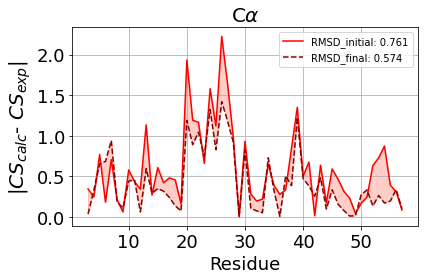

CB
RMSD_initial: 0.646 RMSD_final: 0.416


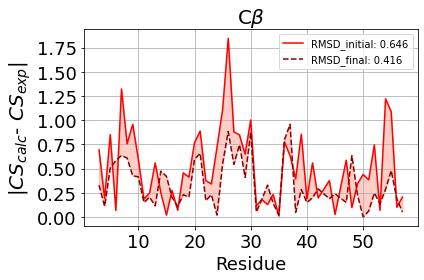

H
RMSD_initial: 0.169 RMSD_final: 0.176


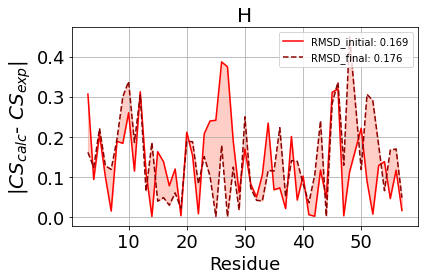

HA
RMSD_initial: 0.170 RMSD_final: 0.104


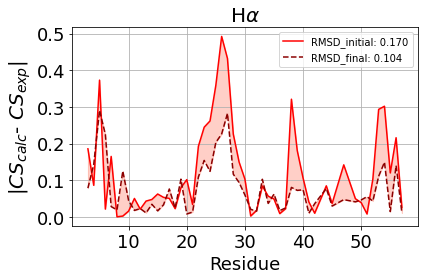

C
RMSD_initial: 0.651 RMSD_final: 0.537


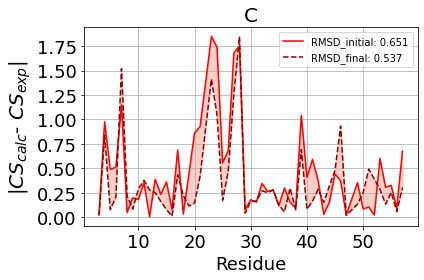

PRE_2
RMSD_initial: 0.296 RMSD_final: 0.166


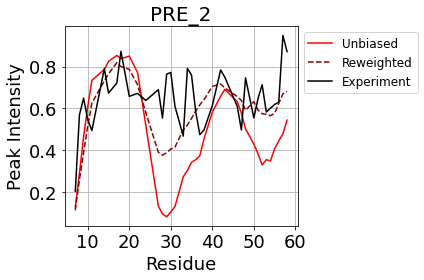

PRE_59
RMSD_initial: 0.380 RMSD_final: 0.209


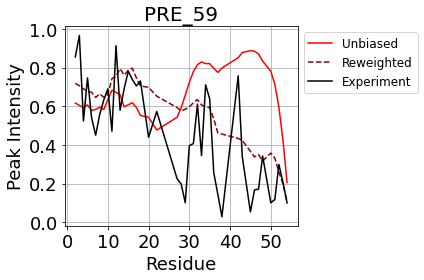

JHNHA
RMSD_initial: 1.050 RMSD_final: 0.694


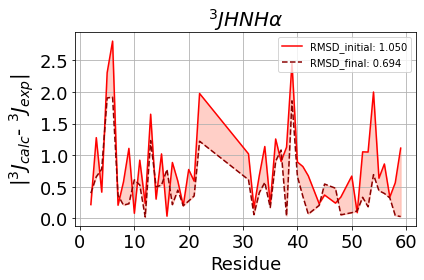

SAXS
RMSD_initial: 0.004 RMSD_final: 0.002


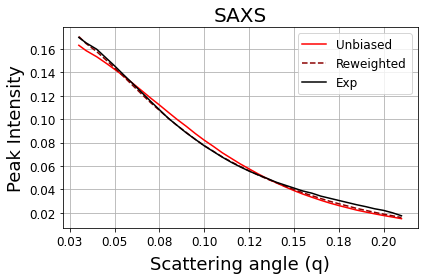

RDC
RMSD_initial: 1.056 RMSD_final: 1.119
RMSD initial scale: 1.056 RMSD final scale: 1.108
Q initial scale: 0.944 Q final scale: 0.991


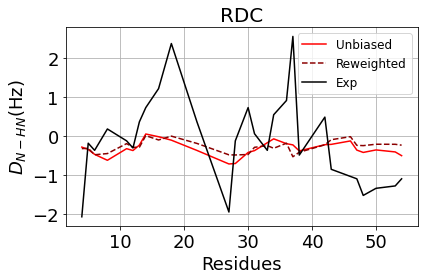

CA-CB-H-HA-C-PRE_2-PRE_59-JHNHA-SAXS-RDC Theta: 0.01 Kish:  0.096605 RMSD initail: 0.6119 RMSD final: 0.4791
Initial RMSE reweight data 
 * Total :      0.612
 *    CA :      0.761
 *    CB :      0.646
 *     H :      0.169
 *    HA :      0.170
 *     C :      0.651
 *    PRE_2 :      0.296
 *    PRE_59 :      0.380
 *    JHNHA :      1.050
 *    SAXS :      0.004
 *    RDC :      1.056
 *    RDC scaled Q:  0.944
Final RMSE reweight data
 * Total :      0.479
 *    CA :      0.574
 *    CB :      0.416
 *     H :      0.176
 *    HA :      0.104
 *     C :      0.537
 *    PRE_2 :      0.166
 *    PRE_59 :      0.209
 *    JHNHA :      0.694
 *    SAXS :      0.002
 *    RDC :      1.119
 *    RDC Q_scaled:  0.991


<Figure size 432x288 with 0 Axes>

In [14]:
To_Scan=combined_reweighting_keys


CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(To_Scan[0], true_exp_labels)
obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)


s = '{:.2f}'.format(theta_m)

sigma_reg=theta_m*err_r
sigma_md=sigma_md_r


        

nobs_r = len(obs_exp_r)
nobs_v = len(obs_exp_v)
weight_bias=np.ones(nframes)
if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       #print(qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos)    
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
       #print(qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c


res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
initial_weights = Normalize_Weights(weight_bias)
initial_obs_r=np.dot(traj_r,initial_weights)
final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
final_obs_r=np.dot(traj_r,final_weights)
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
        
Kish_ratio = (Ks_a/Ks_b)*100
RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

plot_fitting_data(final_weights)
print_comb_results()

np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
# print final weights to file

f = open("%s/weights_final.a.dat" % CS_dir, "w")
for w in final_weights:
       f.write("%e\n" % w)
f.close()

### SAVING ALL THE INFORMATION FROM THE OPTIMIZED REWEIGHTING ROUNDS AS DICTIONARIES TO LOAD FOR MAKING THE ANALYSIS PLOTS

In [16]:
import pickle

with open('%s/RMSE_single.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(RMSE_dict, fp)



with open('%s/RMSE_combined.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(RMSE_dict_combined, fp)

with open('%s/theta_dict.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(theta_dict, fp)

with open('%s/theta_dict_combined.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(theta_dict_combined, fp)



with open('%s/KishScan_single_data.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(KishScan_one_data, fp)



with open('%s/KishScan_combined.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(KishScan_combined, fp)

with open('%s/colors.pkl' % dic_dir, 'wb') as fp:
    pickle.dump(colors, fp)

In [17]:
def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1
 dsspH[dsspH=='E']=0
 dsspH[dsspH=='C']=0
 dsspH[dsspH=='NA']=0
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1)
 SE_H=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspH[:,i].astype(float)
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5]

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1)
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)
 SE_E=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
 return SE_H, SE_E


In [33]:
pdb = '/Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN/drkN.pdb'
trajectory = '/Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN/Charmm36m/drkN-Charmm36m-Traj.dcd'
helixpdb = '/Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN/drkN.helix.pdb'
# outdir = '/Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN/a99SBdisp/reweight_trial/ensembles/'
weight_file = '/Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN/Charmm36m/reweight_kish_tiny/weights/combined_data/CA-CB-H-HA-C-PRE_2-PRE_59-JHNHA-SAXS-RDC/weights_final.dat'
#weight_file = '/Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN/a99SBdisp/reweight_kish_tiny/weights/combined_data/CA-CB-H-HA-C-PRE_2-PRE_59-JHNHA-SAXS-RDC/weights_final.dat'
weights=np.loadtxt(weight_file)


if not os.path.exists(outdir):
    os.makedirs(outdir)


print("outdir",outdir)
print("pdb",pdb)
print("helixpdb",helixpdb)
print("trajectory",trajectory)
print("weights_file",weight_file)

outdir /Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN/Charmm36m/reweight_kish_tiny
pdb /Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN/drkN.pdb
helixpdb /Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN/drkN.helix.pdb
trajectory /Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN/Charmm36m/drkN-Charmm36m-Traj.dcd
weights_file /Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN/Charmm36m/reweight_kish_tiny/weights/combined_data/CA-CB-H-HA-C-PRE_2-PRE_59-JHNHA-SAXS-RDC/weights_final.dat


In [19]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq

In [20]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
trj = trj[1:]
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [21]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
prot_top=top.subset(top.select('protein'))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
residues=len(set(prot_res))

In [22]:
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 939

Number of residues: 59

Number of protein residues: 59

Number of frames: 29976

Starting frame: 0

Last frame: 29976

sequence:  [MET1, GLU2, ALA3, ILE4, ALA5, LYS6, HIS7, ASP8, PHE9, SER10, ALA11, THR12, ALA13, ASP14, ASP15, GLU16, LEU17, SER18, PHE19, ARG20, LYS21, THR22, GLN23, ILE24, LEU25, LYS26, ILE27, LEU28, ASN29, MET30, GLU31, ASP32, ASP33, SER34, ASN35, TRP36, TYR37, ARG38, ALA39, GLU40, LEU41, ASP42, GLY43, LYS44, GLU45, GLY46, LEU47, ILE48, PRO49, SER50, ASN51, TYR52, ILE53, GLU54, MET55, LYS56, ASN57, HIS58, ASP59]

residue names:  ['MET', 'GLU', 'ALA', 'ILE', 'ALA', 'LYS', 'HIS', 'ASP', 'PHE', 'SER', 'ALA', 'THR', 'ALA', 'ASP', 'ASP', 'GLU', 'LEU', 'SER', 'PHE', 'ARG', 'LYS', 'THR', 'GLN', 'ILE', 'LEU', 'LYS', 'ILE', 'LEU', 'ASN', 'MET', 'GLU', 'ASP', 'ASP', 'SER', 'ASN', 'TRP', 'TYR', 'ARG', 'ALA', 'GLU', 'LEU', 'ASP', 'GLY', 'LYS', 'GLU', 'GLY', 'LEU', 'ILE', 'PRO', 'SER', 'ASN', 'TYR', 'ILE', 'GLU', 'MET', 'LYS', 'ASN', 'HIS', 

In [23]:
residue_offset=0
prot_res_renum=np.asarray(prot_res)+residue_offset
residue_number = range(0,residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:",residue_number)

Residue Number Range: range(0, 59)


In [24]:
def block(x):
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    for i in arange(0,d):
        n = len(x)
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        s[i] = var(x)
        x = 0.5*(x[0::2] + x[1::2])

    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))

In [25]:
dssp=md.compute_dssp(trj, simplified=True)
np.savetxt(outdir+"/dssp.out",dssp,fmt='%s')
H1_H,H1_E=dssp_convert(dssp)

/Users/kaushikborthakur1211/opt/anaconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [26]:
dsspH=np.copy(dssp)
dsspH[dsspH=='H']=1
dsspH[dsspH=='E']=0
dsspH[dsspH=='C']=0
dsspH[dsspH=='NA']=0
dsspH=dsspH.astype(int)
np.savetxt(outdir+"/dssp.H.dat",dsspH,fmt='%i')
np.savetxt(outdir+"/Hprop.dat",np.column_stack((prot_res_renum,H1_H)),fmt="%.3f")

In [27]:
dsspE=np.copy(dssp)
dsspE[dsspE=='H']=0
dsspE[dsspE=='E']=1
dsspE[dsspE=='C']=0
dsspE[dsspE=='NA']=0
dsspE=dsspE.astype(int)
np.savetxt(outdir+"/dssp.E.dat",dsspE,fmt='%i')
np.savetxt(outdir+"/Eprop.dat",np.column_stack((prot_res_renum,H1_E)),fmt="%.3f")

In [35]:
Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspH)
Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)

reweight_Hprop=[]
reweight_Eprop=[]
for i in range(0,len(Hprop)):
    reweight_Hprop.append(np.dot(dsspH[:,i],weights))
    reweight_Eprop.append(np.dot(dsspE[:,i],weights))

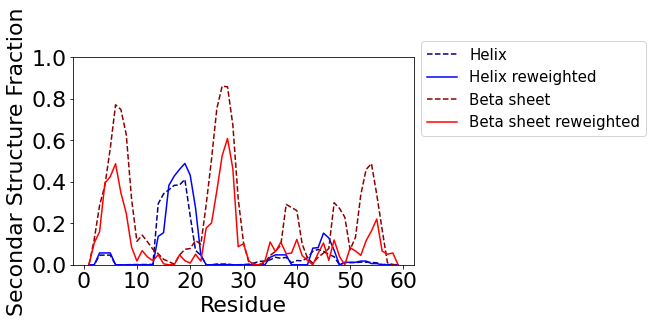

In [36]:
plt.clf()
plt.plot(prot_res_renum,Hprop,color='darkblue', label='Helix',linestyle='dashed')
plt.ylim(0,1.0)
plt.plot(prot_res_renum,reweight_Hprop,color='blue', label='Helix reweighted')
plt.plot(prot_res_renum,Eprop,color='darkred', label='Beta sheet',linestyle='dashed')
plt.plot(prot_res_renum,reweight_Eprop,color='red', label='Beta sheet reweighted')
plt.xlabel('Residue', size=22)
plt.ylabel('Secondar Structure Fraction', size=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.85), fontsize=15)
plt.savefig('%s/SS.reweight.pdf'%outdir, bbox_inches='tight')

In [38]:
og_weights = np.loadtxt('/Users/kaushikborthakur1211/Desktop/Paper_Repo/drkN/Charmm36m/reweight_trial/weights/combined_data/CA-CB-H-HA-C-PRE_2-PRE_59-JHNHA-SAXS-RDC/weights_final.dat')

In [41]:
if np.any(og_weights != weights):
    print("The weights are different")
else:
    print("The weights are identical.")


The weights are different


In [42]:
x = og_weights - weights

In [43]:
x

array([ 4.04569034e-04, -1.15788175e-02,  3.77857339e-04, ...,
        6.36165300e-06,  6.11397500e-06,  3.32537200e-06])